VLM - Vision Language Model

VLMs are a type of artificial intelligence (AI) model that can understand and process both visual and textual information. This means they can "see" and "read" at the same time, allowing them to perform tasks that require understanding both images and text.

Working:

Input: VLMs take both images and text as input. The images are usually processed by a convolutional neural network (CNN) to extract visual features, while the text is processed by a transformer-based language model to extract textual features. Fusion: The visual and textual features are then fused together using various techniques, allowing the model to learn the relationships between the two modalities.

Output: VLMs can produce different types of output depending on the task, such as generating captions for images, answering questions about images, or even generating new images based on textual descriptions.





### Problem Definition

Given the visual puzzle, the goal is to leverage vision-language models (VLMs) to analyze the image, apply reasoning to understand patterns, relationships, and logical rules, and select the correct answer from the provided options.

**Question:** What is the missing number of the part denoted with a question mark?

**Options:**  
- [7, 9, 1, 5]



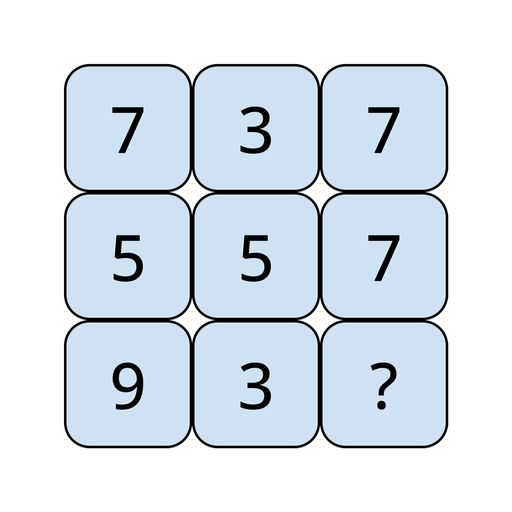

Install all the requirements

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
!pip install json_repair

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mount drive and download dataset in colab

In [ ]:
!unzip "/content/drive/MyDrive/PuzzleVQA.zip"

Archive:  /content/drive/MyDrive/PuzzleVQA.zip
   creating: PuzzleVQA/
  inflating: __MACOSX/._PuzzleVQA    
  inflating: PuzzleVQA/.DS_Store     
  inflating: __MACOSX/PuzzleVQA/._.DS_Store  
  inflating: PuzzleVQA/requirements.txt  
  inflating: __MACOSX/PuzzleVQA/._requirements.txt  
  inflating: PuzzleVQA/data_loading.py  
  inflating: __MACOSX/PuzzleVQA/._data_loading.py  
  inflating: PuzzleVQA/.env.sample   
  inflating: __MACOSX/PuzzleVQA/._.env.sample  
  inflating: PuzzleVQA/evaluate.sh   
  inflating: __MACOSX/PuzzleVQA/._evaluate.sh  
  inflating: PuzzleVQA/prompting.py  
  inflating: __MACOSX/PuzzleVQA/._prompting.py  
  inflating: PuzzleVQA/README.md     
  inflating: __MACOSX/PuzzleVQA/._README.md  
  inflating: PuzzleVQA/main.py       
  inflating: __MACOSX/PuzzleVQA/._main.py  
  inflating: PuzzleVQA/modeling.py   
  inflating: __MACOSX/PuzzleVQA/._modeling.py  
   creating: PuzzleVQA/data/
  inflating: __MACOSX/PuzzleVQA/._data  
   creating: PuzzleVQA/generation/
  i

Imports

In [ ]:
import pandas as pd
import json
import os
import json_repair

from PIL import Image
import random
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from datasets import Dataset, DatasetDict
from trl import SFTTrainer, SFTConfig
import re
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator




**Preprocessing data**

JSON files contain data, so we load the JSON file and convert it into DataFrames for preprocessing.

In [ ]:
# Define folder path in Google Drive
folder_path = "/content/PuzzleVQA/data"

# List all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each JSON file and convert to DataFrame
for file in json_files:
    data = []
    file_path = os.path.join(folder_path, file)

    with open(file_path, "r") as f:
        data = json_repair.loads(f.read())   # Load JSON file as dictionary

    # Convert to DataFrame
    df = pd.DataFrame(data)
    dfs.append(df)

# Concatenate all DataFrames into one (if they have the same structure)
final_df = pd.concat(dfs, ignore_index=True)

In [ ]:
len(final_df)

76

Conveting image in pillow format : Python library supporting wide formats of images.

In [ ]:
pill_images = []
for img_path in final_df["image"]:
  image = Image.open(os.path.join("/content/PuzzleVQA/data",img_path))
  pill_images.append(image)

Drop image path column as we don't need it now for training

In [ ]:
final_df.drop("image", axis=1, inplace=True)

Adding pillow images as column in dataframe

In [ ]:
final_df["image"] = pill_images

**Preview of dataset**


In [ ]:
final_df.head()

,question,answer,options,caption,explanation,deduction,image
0,What is the missing color of the part denoted ...,blue,"[yellow, purple, blue, orange]",There is a hexagon split into six parts with t...,We observe that a orange part is opposite anot...,Based on the pattern that spatially opposite p...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,What is the missing color of the part denoted ...,green,"[red, green, blue, purple]",There is a hexagon split into six parts with t...,We observe that a purple part is opposite anot...,Based on the pattern that spatially opposite p...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,What is the missing color of the part denoted ...,purple,"[purple, green, orange, yellow]",There is a hexagon split into six parts with t...,We observe that a blue part is opposite anothe...,Based on the pattern that spatially opposite p...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,What is the missing color of the part denoted ...,orange,"[orange, blue, red, yellow]",There is a hexagon split into six parts with t...,We observe that a blue part is opposite anothe...,Based on the pattern that spatially opposite p...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,What is the missing color of the part denoted ...,blue,"[blue, yellow, green, orange]",There is a hexagon split into six parts with t...,We observe that a green part is opposite anoth...,Based on the pattern that spatially opposite p...,<PIL.PngImagePlugin.PngImageFile image mode=RG...


Converting into chat format to load it into models

It allows for a more natural and interactive way to query and interact with the model. Users can ask questions or provide instructions in a conversational style, making the experience more user-friendly.

There are two roles (distinguishes different participants in the conversation)-

User : Provides input, guide the conversation(helping model understand user's intention and refines its responses)

Assisstant : Generates output based on its understanding.

In [ ]:
instruction = "Solve the puzzle for this image and select answer from given options only."

def convert_to_conversation(row):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction + " " +row["question"] + " options are " + str(row["options"])},
            {"type" : "image", "image" : row["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : "Solution of the problem- "+ row["explanation"] + " now solve it step by step- " + row["deduction"] + " and the option can be selected is " + str(row["answer"])} ]
        },
    ]
    return { "messages" : conversation }
pass

In [ ]:
converted_dataset = []
for _, row in final_df.iterrows():
  converted_dataset.append(convert_to_conversation(row))
random.shuffle(converted_dataset)

**Preview of chat template**


In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are ['7', '2', '1', '6']"},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Solution of the problem- We observe that the circles with 2 and 3 overlap to form the part 5, where 2 + 3 = 5. Hence, the pattern is most likely that the numbers in the overlapping parts are the sum of the numbers in the corresponding circles. now solve it step by step- Based on the pattern that the numbers in the overlapping parts are the sum of the numbers in the corresponding circles, the missing number of the circle where the overlapping part is 10 should be 7. and the option can be selected is 7'}]}]}

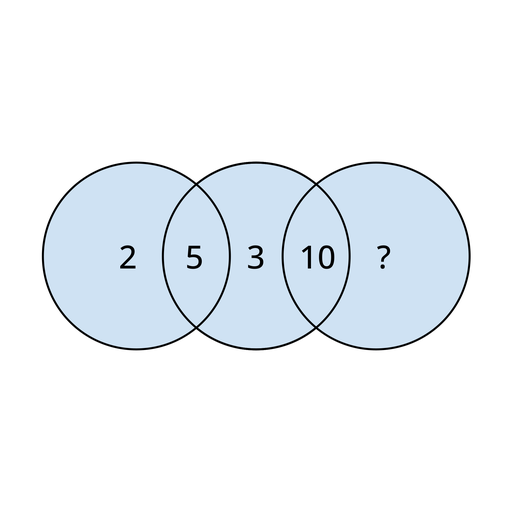

In [ ]:
converted_dataset[0]["messages"][0]['content'][1]['image']

Split Data : Splitting data into train, test and validation for evaluation and fine tuning.

In [ ]:
train_dataset = converted_dataset[:1800]
eval_dataset = converted_dataset[1800:1900]
test_dataset = converted_dataset[1900:]

**Inference** : The process of using a trained model to make predictions or generate outputs on new, unseen data, essentially putting the model into action.

**Inferencing without fine tuning**

**Llama-3.2**

In [ ]:
max_seq_length = 1024
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

llama_model, llama_tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

In [ ]:
test_dataset[0]["messages"]

[{'role': 'user',
  'content': [{'type': 'text',
    'text': "Solve the puzzle for this image and select answer from given options only. What is the missing color of the part denoted with a question mark? options are ['orange', 'blue', 'purple', 'yellow']"},
   {'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Solution of the problem- We observe that the polygon with 9 sides is orange in color and the polygon with 7 sides is blue in color. Thus, the pattern is that the polygons with the same number of sides have the same color. now solve it step by step- Based on the pattern that the polygons with the same number of sides have the same color, the missing color of the part with 3 sides should be yellow. and the option can be selected is yellow'}]}]

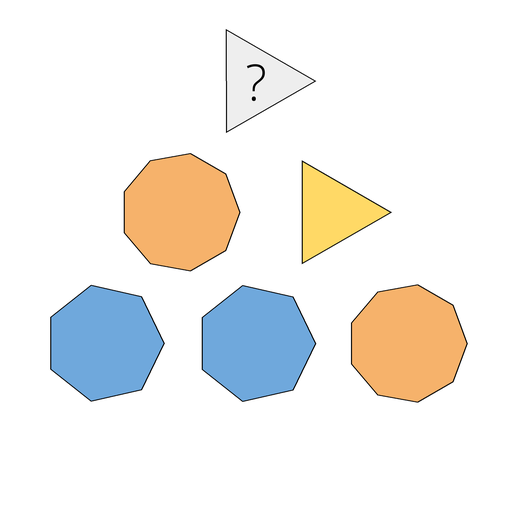

In [ ]:
test_dataset[0]["messages"][0]['content'][1]['image']

In [ ]:
FastVisionModel.for_inference(llama_model) # Enable for inference!

image = test_dataset[0]["messages"][0]['content'][1]['image']
instruction = "Solve the puzzle for this image and select answer from given options only."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction + " " + test_dataset[1]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = llma_tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = llma_tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(llama_tokenizer, skip_prompt = True)
_ = llama_model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The image presents a pattern of geometric shapes, including triangles and hexagons. The triangle in the upper left corner is accompanied by a question mark. Below it are three hexagons arranged horizontally, followed by a triangle on the right side. This pattern suggests that each part, including the question-marked triangle, is part of a sequence or progression.

To solve for the missing number represented by the question mark, we need to understand the relationship between the different parts. Observing the shapes and their arrangements:

*   The triangle above has no shape associated with it in the options.
*   The triangle below appears to be a standard triangular


**Gemma-3**

In [ ]:
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Gemma3 patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/4.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [ ]:
def apply_chat_template(example):
    formatted_texts = []

    for message in example['messages']:
        if message['role'] == 'user':
            image_tag = "<start_of_image>"  # Placeholder for image processing
            if any(item['type'] == 'image' for item in message['content']):
                image_data = next(item for item in message['content'] if item['type'] == 'image')['image']
                image_tag = f"<start_of_image>{image_data}"  # Ensure image is properly included

            text = f"<bos><start_of_turn>user\n{message['content'][0]['text']}{image_tag}<end_of_turn>\n"
        elif message['role'] == 'assistant':
            text = f"<start_of_turn>model\n{message['content'][0]['text']}<end_of_turn>\n"
        formatted_texts.append(text)

    return {"text": "".join(formatted_texts)}

dataset = []
for d in test_dataset:
    dataset.append(apply_chat_template(d))
    test_dataset = Dataset.from_dict({"text": [item["text"] for item in dataset]})

dataset = []
for d in train_dataset:
    dataset.append(apply_chat_template(d))
    train_dataset = Dataset.from_dict({"text": [item["text"] for item in dataset]})

dataset = []
for d in eval_dataset:
    dataset.append(apply_chat_template(d))
    eval_dataset = Dataset.from_dict({"text": [item["text"] for item in dataset]})

In [ ]:
test_dataset[1]

{'text': '<bos><start_of_turn>user\nSolve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are [9, 5, 6, 8]<start_of_image><PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7E2F294DED90><end_of_turn>\n<start_of_turn>model\nSolution of the problem- We observe that the polygon with 4 sides has the number 4, the polygon with 7 sides has the number 7, the polygon with 5 sides has the number 5, the polygon with 3 sides has the number 3, and the polygon with 8 sides has the number 8. Thus, the pattern is that the number inside the polygon represents the number of sides the polygon has. now solve it step by step- Based on the pattern that the number inside the polygon represents the number of sides of the polygon, the missing number of the polygon with 6 sides should be 6. and the option can be selected is 6<end_of_turn>\n'}

In [ ]:
data = test_dataset[1]

# Extract the string until <start_of_turn> using regex
extracted_text = re.split(r'<start_of_turn>model', data['text'])[0]
print(extracted_text)

<bos><start_of_turn>user
Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are [9, 5, 6, 8]<start_of_image><PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7E2F294DED90><end_of_turn>



In [ ]:
user_input = extracted_text
# Prepare input for the model (just the user part)
inputs = tokenizer([user_input], return_tensors="pt").to("cuda")

# Generate the model's response
outputs = model.generate(
    **inputs,
    max_new_tokens=120,  # Adjust for longer outputs
    temperature=1.0,
    top_p=0.95,
    top_k=64,
    streamer=TextStreamer(tokenizer, skip_prompt=True),
)

# Decode the model's response
generated_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated Output: {generated_output}")

*Image description: The image shows a grid of numbers. The grid is 3x3, with the numbers 1, 2, 3, 4, 5, 6, 7, 8, and 9 arranged in a specific pattern. The numbers are arranged in a way that the sum of each row, column, and diagonal is equal to 15. The numbers 1, 2, 3, 4, 5, 6, 7, 8, and 9 are arranged in a 3x3 grid.
Generated Output: user
Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are [9, 5, 6, 8]<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7E2F294DED90>
*Image description: The image shows a grid of numbers. The grid is 3x3, with the numbers 1, 2, 3, 4, 5, 6, 7, 8, and 9 arranged in a specific pattern. The numbers are arranged in a way that the sum of each row, column, and diagonal is equal to 15. The numbers 1, 2, 3, 4, 5, 6, 7, 8, and 9 are arranged in a 3x3 grid.


**Qwen2**

In [ ]:
max_seq_length = 1024
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-2B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[0]["messages"][0]['content'][1]['image']
instruction = "Solve the puzzle for this image and select answer from given options only."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction + " " + test_dataset[0]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The missing part denoted with a question mark is 'small'.<|im_end|>


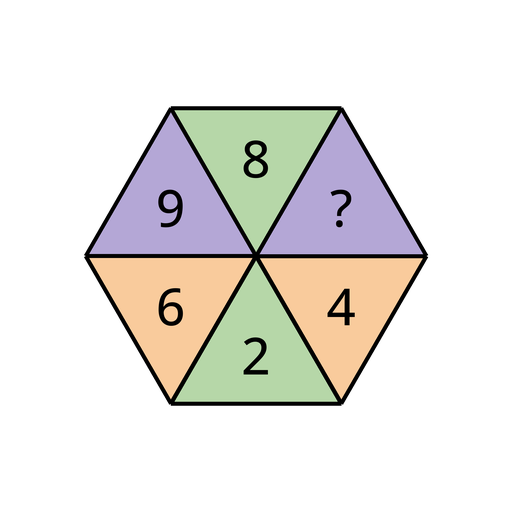

In [ ]:
test_dataset[0]["messages"][0]['content'][1]['image']

In [ ]:
test_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are ['2', '6', '5', '1']"},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Solution of the problem- We observe that the numbers in the green parts add up to 10. Similarly, the numbers in the orange parts also add up to 10. Thus, the pattern is that the numbers in the parts of the same color add up to 10. now solve it step by step- Based on the pattern that the numbers in the parts of the same color add up to 10, the missing number of the purple part should be 1. and the option can be selected is 1'}]}]}

**Pixtral**

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Pixtral-12B-2409-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    # supports_sdpa=False, # Disable SDPA usage.
)

==((====))==  Unsloth 2025.3.19: Fast Llava patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Llava does not support SDPA - switching to eager!


model.safetensors.index.json:   0%|          | 0.00/316k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.57G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/177k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[0]["messages"][0]['content'][1]['image']
instruction = "Solve the puzzle for this image and select answer from given options only."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction + " " + test_dataset[0]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# Remove token_type_ids from the inputs dictionary
if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

The missing number is 6 is 5 to the answer is 1.

To solve the following 6. 'is 1

The 5., 'to the 6. and solve  is 1.

The 5., 'the 6. is 2, 5. to the 1.

The 5. is 2, 'the 6. answere 5 the 1. answere 6. the 5. an 2., the 6. ans 1. to the 5. is 2. the 6. ans 5., the 1


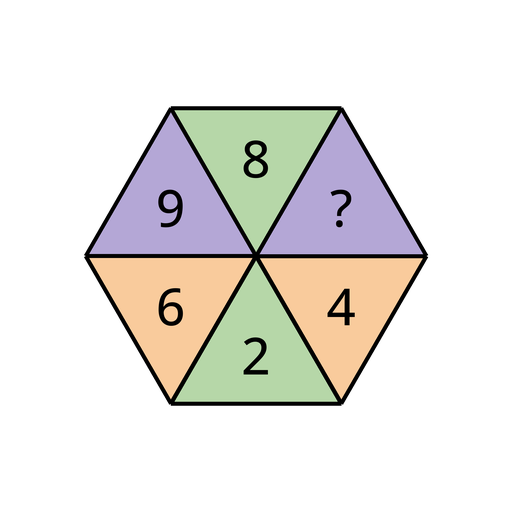

In [ ]:
test_dataset[0]["messages"][0]['content'][1]['image']

In [ ]:
test_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are ['2', '6', '5', '1']"},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Solution of the problem- We observe that the numbers in the green parts add up to 10. Similarly, the numbers in the orange parts also add up to 10. Thus, the pattern is that the numbers in the parts of the same color add up to 10. now solve it step by step- Based on the pattern that the numbers in the parts of the same color add up to 10, the missing number of the purple part should be 1. and the option can be selected is 1'}]}]}

**Fine Tuning** : LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

Training : Huggingface TRL's SFTTrainer(Supervised Fine-Tuning Trainer) is used for training.

UnslothVisionDataCollator is used in vision finetuning setup.

**Llama-3.2**

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


Training

In [ ]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 10,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,800 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


Step,Training Loss
1,2.426300
2,2.512400
3,2.429100
4,2.117800
5,1.934700
6,1.710700
7,1.416000
8,1.218400
9,1.123700
10,0.833600


**Gemma-3**

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    formatting_func = formatting_func,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)



Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=2):   0%|          | 0/1600 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

"<bos><bos><start_of_turn>user\nSolve the puzzle for this image and select answer from given options only. What is the missing shape of the part denoted with a question mark? options are ['pentagon', 'circle', 'square', 'hexagon']<start_of_image><PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F869BF00F50><end_of_turn>\n<start_of_turn>model\nSolution of the problem- We observe that from the top left to bottom right direction, the shapes look like a triangle but gradually change shape into something like a pentagon. Hence, the pattern is the the shapes are morphing between triangle and pentagon shapes. now solve it step by step- Based on the pattern that the shapes are morphing between triangle and pentagon shapes, the missing shape at the bottom right should be a pentagon. and the option can be selected is pentagon<end_of_turn>\n"

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 19,248,896/4,000,000,000 (0.48% trained)


Step,Training Loss
1,0.135900
2,0.125400
3,0.123300
4,0.104100
5,0.101400
6,0.073000
7,0.080500
8,0.091700
9,0.124800
10,0.121300


**Qwen**

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.visual` require gradients


In [ ]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 10,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)


Unsloth: Model does not have a default image size - using 512


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,800 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 28,950,528/2,000,000,000 (1.45% trained)


Step,Training Loss
1,0.712000
2,0.671600
3,0.636400
4,0.759800
5,0.608100
6,0.572100
7,0.616300
8,0.503100
9,0.527900
10,0.426500


In [ ]:
# Saving the Model
model.save_pretrained("lora_model-qwen")
tokenizer.save_pretrained("lora_model-qwen")

[]

**Pixtral**

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_tower.transformer` require gradients


In [ ]:
FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 10,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)



In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,800 | Num Epochs = 1 | Total steps = 10
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288/12,000,000,000 (0.55% trained)


Step,Training Loss
1,12.421900
2,13.664100
3,14.480500
4,12.587900
5,14.732400
6,14.169900
7,13.451200
8,13.414100
9,14.826200
10,14.337900


In [ ]:
model.save_pretrained("drive/MyDrive/PuzzleVQA/models/lora_model-pix")
tokenizer.save_pretrained("drive/MyDrive/PuzzleVQA/models/lora_model-pix")

Inference for fine tunned models

Llama-3.2

In [ ]:
test_dataset[1]["messages"][0]['content'][0]['text']

"Solve the puzzle for this image and select answer from given options only. What is the missing color of the part denoted with a question mark? options are ['green', 'blue', 'orange', 'purple']"

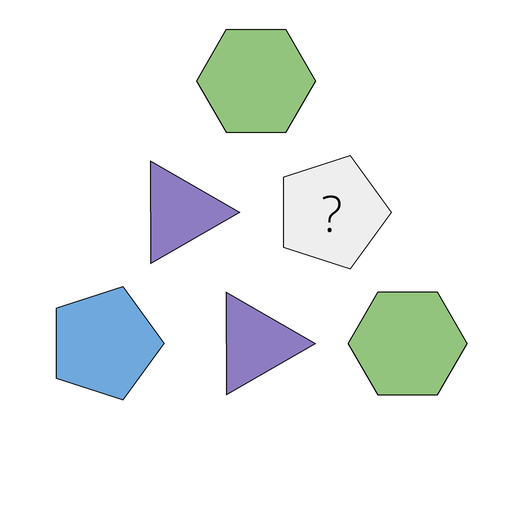

In [ ]:
test_dataset[1]["messages"][0]['content'][1]['image']

In [ ]:
test_dataset[1]["messages"][1]

{'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'Solution of the problem- We observe that the polygon with 3 sides is purple in color and the polygon with 6 sides is green in color. Thus, the pattern is that the polygons with the same number of sides have the same color. now solve it step by step- Based on the pattern that the polygons with the same number of sides have the same color, the missing color of the part with 5 sides should be blue. and the option can be selected is blue'}]}

In [ ]:
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "/content/llama-3.2", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[1]["messages"][0]['content'][1]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": test_dataset[1]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['alpha_pattern', 'bias', 'corda_config', 'eva_config', 'exclude_modules', 'fan_in_fan_out', 'init_lora_weights', 'layer_replication', 'layers_pattern', 'layers_to_transform', 'loftq_config', 'lora_alpha', 'lora_bias', 'lora_dropout', 'megatron_config', 'megatron_core', 'modules_to_save', 'r', 'rank_pattern', 'target_modules', 'trainable_token_indices', 'use_dora', 'use_rslora'] for class PeftConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['corda_config', 'trainable_token_indices'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


Solution of the problem- We observe that the polygon with 3 sides is purple in color and the polygon with 6 sides is green in color. Thus, the pattern is that the polygons with the same number of sides have the same color. now solve it step by step- Based on the pattern that the polygons with the same number of sides have the same color, the missing color of the part with 5 sides should be blue. and the option can be selected is blue<|eot_id|>


gemma-3

In [ ]:
test_datasets["test"][10]

{'text': "<bos><start_of_turn>user\nSolve the puzzle for this image and select answer from given options only. What is the size of the missing part denoted by a question mark? options are ['small', 'medium', 'large']<start_of_image><PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F869BF711D0><end_of_turn>\n<start_of_turn>model\nSolution of the problem- We observe that the columns contain large shapes, medium shapes, and small shapes respectively. On the other hand, the rows contain triangles, pentagons, and squares respectively. Hence, the pattern is that the shapes within each row are the same, while each column progresses the size of the shapes. now solve it step by step- Based on the pattern that the shapes within each row are the same, while each column progresses the size of the shapes, the size of the missing square should be small. and the option can be selected is small<end_of_turn>\n"}

In [ ]:
import re

data = split_datasets["test"][10]

# Extract the string until <start_of_turn> using regex
extracted_text = re.split(r'<start_of_turn>model', data['text'])[0]print(extracted_text)

<bos><start_of_turn>user
Solve the puzzle for this image and select answer from given options only. What is the size of the missing part denoted by a question mark? options are ['small', 'medium', 'large']<start_of_image><PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F869BF711D0><end_of_turn>



In [ ]:
user_input = extracted_text
if False:
    from unsloth import FastModel
    model, tokenizer = FastModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )
# Generate the model's response
outputs = model.generate(
    **inputs,
    max_new_tokens=120,  # Adjust for longer outputs
    temperature=1.0,
    top_p=0.95,
    top_k=64,
    streamer=TextStreamer(tokenizer, skip_prompt=True),
)

# Decode the model's response
generated_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated Output: {generated_output}")


<start_of_turn>model
Solution of the problem- We observe that the columns contain small shapes, medium shapes, and large shapes respectively. On the other hand, the rows contain triangles, pentagons, and hexagons respectively. Hence, the pattern is that the shapes within each row are the same, while each column progresses the size of the shapes. now solve it step by step- Based on the pattern that the shapes within each row are the same, while each column progresses the size of the shapes, the size of the missing triangle should be small. and the option can be selected is small<end_of_turn>
Generated Output: user
Solve the puzzle for this image and select answer from given options only. What is the size of the missing part denoted by a question mark? options are ['small', 'medium', 'large']<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F869BF711D0>
model
Solution of the problem- We observe that the columns contain small shapes, medium shapes, and large shapes respec

In [ ]:
data = test_dataset[:20]
question = []
answer = []

for f in range(len(data)):
  question.append(test_dataset[f]["messages"][0]['content'][0]['text'])
  answer.append(test_dataset[f]["messages"][1]['content'][0]['text'])

**Qwen**

In [ ]:
test_dataset[0]["messages"][0]['content'][0]['text']

"Solve the puzzle for this image and select answer from given options only. What is the missing number of the part denoted with a question mark? options are ['2', '6', '5', '1']"

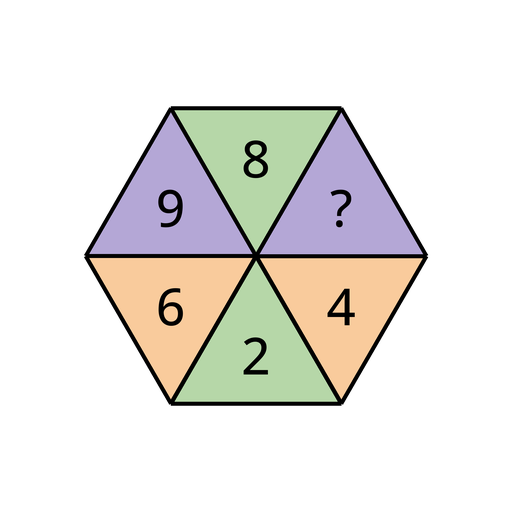

In [ ]:
test_dataset[0]["messages"][0]['content'][1]['image']

In [ ]:
test_dataset[0]["messages"][1]

{'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'Solution of the problem- We observe that the numbers in the green parts add up to 10. Similarly, the numbers in the orange parts also add up to 10. Thus, the pattern is that the numbers in the parts of the same color add up to 10. now solve it step by step- Based on the pattern that the numbers in the parts of the same color add up to 10, the missing number of the purple part should be 1. and the option can be selected is 1'}]}

In [ ]:
# # model download
# !cp -r "drive/MyDrive/PuzzleVQA/models/lora_model-qwen" "lora_model-qwen"

In [ ]:
from unsloth import FastVisionModel
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "lora_model-qwen", # YOUR MODEL YOU USED FOR TRAINING
    load_in_4bit = True, # Set to False for 16bit LoRA
)
FastVisionModel.for_inference(model) # Enable for inference!



==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Solution of the problem- We observe that the circles at the corners are large size, while the circles directly adjacent to the center are medium size. Only the center circle is small size. Hence, the pattern is that the circles alternate in size depending on if they are at the corner or adjacent to the center. now solve it step by step- Based on the pattern that the circles alternate in size depending on if they are at the corner or adjacent to the center, the size of the missing part that is adjacent to the center should be small. and t

In [ ]:
image = test_dataset[0]["messages"][0]['content'][1]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": test_dataset[3]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Solution of the problem- We observe that the numbers in the green parts add up to 15. Similarly, the numbers in the orange parts also add up to 15. Thus, the pattern is that the numbers in the parts of the same color add up to 15. now solve it step by step- Based on the pattern that the numbers in the parts of the same color add up to 15, the missing number of the purple part should be 1. and the option can be selected is 1<|im_end|>


**Pixtral**

In [ ]:
test_dataset[0]["messages"][0]['content'][0]['text']

"Solve the puzzle for this image and select answer from given options only. What is the missing color of the part denoted with a question mark? options are ['light blue', 'dark red', 'light orange', 'dark orange']"

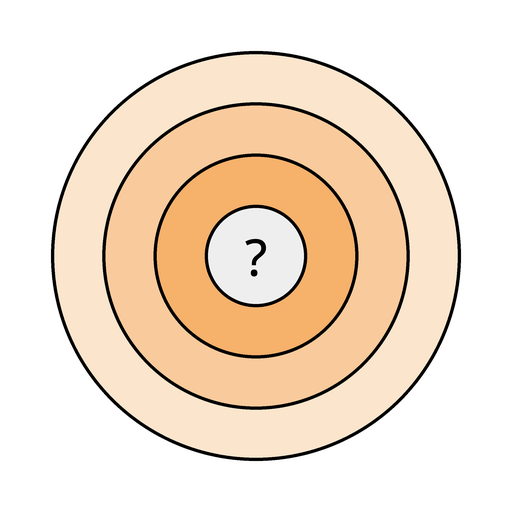

In [ ]:
test_dataset[0]["messages"][0]['content'][1]['image']

In [ ]:
test_dataset[0]["messages"][1]

{'role': 'assistant',
 'content': [{'type': 'text',
   'text': 'Solution of the problem- We observe that the largest circle is very light orange color, and the smaller circles change color from light orange to medium orange. Hence, the pattern is that the circles become darker as they become smaller. now solve it step by step- Based on the pattern that the circles become darker as they become smaller, the missing color of the smallest circle denoted with a question mark should be dark orange. and the option can be selected is dark orange'}]}

In [ ]:
# model download
!cp -r "drive/MyDrive/PuzzleVQA/models/lora_model-pix" "lora_model-pix"

In [ ]:
from unsloth import FastVisionModel
import torch
# Delete model and tokenizer to release memory
# del model
# del tokenizer
# # Attempt to clear GPU cache
# torch.cuda.empty_cache()
# Try loading the model in 8-bit to save memory.
model, tokenizer = FastVisionModel.from_pretrained(
    model_name="lora_model-pix",  # Correct model path?
    load_in_4bit=True,  # Changed to load in 8-bit or more memory
)

==((====))==  Unsloth 2025.3.19: Fast Mistral patching. Transformers: 4.50.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Mistral does not support SDPA - switching to eager!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
image = test_dataset[0]["messages"][0]['content'][1]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": test_dataset[2]["messages"][0]['content'][0]["text"]}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# Remove token_type_ids from the inputs dictionary
if "token_type_ids" in inputs:
    del inputs["token_type_ids"]

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Solution of the problem- We observe that the largest circle is very light orange color, and the smaller the circle the darker the color. Hence, the pattern is that the circles change color from light orange to medium orange. now solve it step by step- Based on the pattern that the circles change color from light orange to medium orange, the size of the circle denoted with a question mark is the smallest. and the missing color of the smallest circle should be dark orange. and the option can be selected is dark orange</s>


Accuracy

In [ ]:
import pandas as pd
df = pd.read_csv("/content/results - Gemma.csv")
df.head()

,Unnamed: 0,Unnamed: 1,Gemma,Unnamed: 3,Llama,Unnamed: 5,Qwen,Unnamed: 7,Pixtral,Unnamed: 9
0,Question,Answer,Answer without fine tuning,Answer after fine tuning,Answer without fine tuning,Answer after fine tuning,Answer without fine tuning,Answer after fine tuning,Answer without fine tuning,Answer after fine tuning
1,Solve the puzzle for this image and select ans...,5,0,1,0,0,1,1,0,0
2,Solve the puzzle for this image and select ans...,large,0,1,0,1,1,1,0,1
3,Solve the puzzle for this image and select ans...,yellow,1,1,1,1,0,1,0,1
4,Solve the puzzle for this image and select ans...,pentagon,0,1,0,0,0,0,0,0


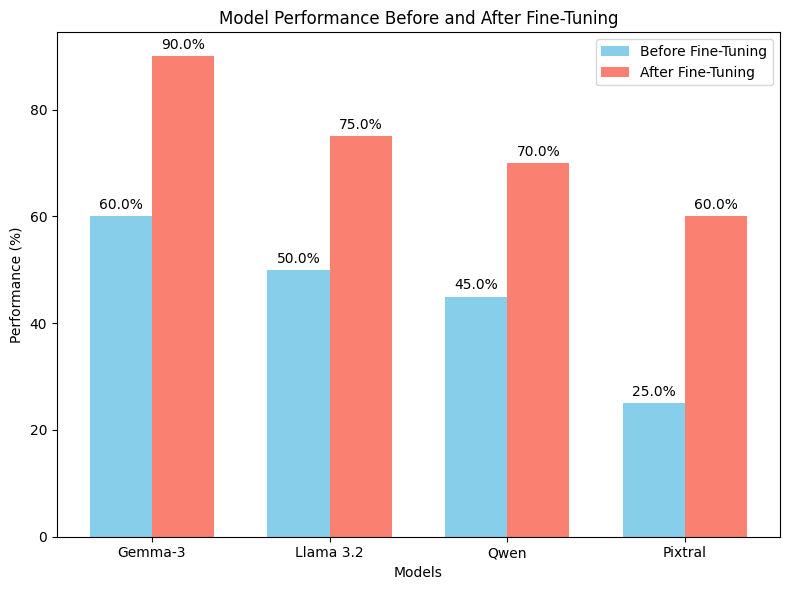

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Gemma-3', 'Llama 3.2', 'Qwen', 'Pixtral']

# Scores before fine-tuning (out of 20 samples)
scores_before = [12, 10, 9, 5]

# Scores after fine-tuning (out of 20 samples)
scores_after = [18, 15, 14, 12]

# Calculate percentages
percent_before = [score / 20 * 100 for score in scores_before]
percent_after = [score / 20 * 100 for score in scores_after]

# X-axis positions for the bars
x = np.arange(len(models))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Bar width
width = 0.35

# Plot bars for before and after fine-tuning
bars_before = ax.bar(x - width/2, percent_before, width, label='Before Fine-Tuning', color='skyblue')
bars_after = ax.bar(x + width/2, percent_after, width, label='After Fine-Tuning', color='salmon')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Performance (%)')
ax.set_title('Model Performance Before and After Fine-Tuning')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the percentage values on top of the bars
def add_labels(bars, scores):
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.annotate(f'{score}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset label slightly
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars_before, percent_before)
add_labels(bars_after, percent_after)

# Show the plot
plt.tight_layout()
plt.show()


Observation

## Observations on Model Performance

We tested four models—**Gemma**, **Llama**, **Qwen**, and **Pixtral**—to evaluate their performance both **without fine-tuning** and **after fine-tuning** on **20 samples**. Below are the results:

| Model   | Answer without Fine-tuning | Answer after Fine-tuning |
|---------|----------------------------|--------------------------|
| Gemma   | 12                         | 18                       |
| Llama   | 10                         | 15                       |
| Qwen    | 9                          | 14                       |
| Pixtral | 5                          | 12                       |

### Performance Analysis

1. **Gemma-3**:
   - Gemma shows the highest improvement in performance after fine-tuning, with a score increase from **12** to **18**.
   - This indicates that Gemma benefits significantly from fine-tuning, suggesting that it adapts well to the specific task or dataset.

2. **Llama-3.2**:
   - Llama also shows a notable increase in performance, from **10** to **15**.
   - Although the improvement is substantial, it is slightly less than that of Gemma, but still indicates the positive effect of fine-tuning.

3. **Qwen**:
   - Qwen demonstrates a moderate improvement, moving from **9** to **14**.
   - This suggests that Qwen, while benefiting from fine-tuning, may not perform as effectively as Gemma and Llama on this particular task.

4. **Pixtral**:
   - Pixtral shows the lowest performance both before and after fine-tuning, with a score of **5** without fine-tuning and **12** after fine-tuning.
   - Although Pixtral does show an improvement, it still lags behind the other models, indicating it may need more data or adjustments to improve performance significantly.

   **Additionaly** requires fewer training steps to learn effectively—only **100 steps**, compared to the other models that require at least **200 steps**. This indicates that Gemma is more efficient in terms of learning and adapting to new data.

### Conclusion

- **Gemma** outperforms the other models both in raw score and in improvement after fine-tuning, making it the most effective choice for this task.
- **Fine-tuning** generally leads to improved performance across all models, confirming that adapting the models to the specific dataset or task is crucial for boosting their accuracy and relevance.
